# Testing Trained Models on New Single Cell Dataset

This notebook demonstrates how to load new single cell data and test it using the trained RNA-to-ADT transformer mapping models.

## Overview
1. Load new single cell RNA data
2. Load pre-trained models
3. Preprocess new data
4. Extract embeddings and make predictions
5. Evaluate performance (if ground truth available)
6. Visualize results


## 1. Setup and Imports


In [1]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add project root to Python path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("=== Setup Information ===")
print(f"Current directory: {current_dir}")
print(f"Project root: {project_root}")
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/an

=== Setup Information ===
Current directory: /projects/vanaja_lab/satya/DeepOMAPNet/Tutorials
Project root: /projects/vanaja_lab/satya/DeepOMAPNet
Python version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA H200
CUDA memory: 150.1 GB


In [2]:
import sys, os, importlib

# --- Paths ---
current_dir = os.getcwd()  # This will be .../DeepOMAPNet/Notebooks
project_root = os.path.dirname(current_dir)  # This will be .../DeepOMAPNet

# Add project root to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Added to Python path:")
print(f"- Current directory: {current_dir}")
print(f"- Project root: {project_root}")
print(f"- Scripts directory exists: {os.path.exists(os.path.join(project_root, 'scripts'))}")
print(f"- Scripts/data_provider exists: {os.path.exists(os.path.join(project_root, 'scripts', 'data_provider'))}")

# Clear any cached imports
importlib.invalidate_caches()

# --- Import modules (module-style, not from ... import ...) ---
import scripts.data_provider.data_preprocessing as data_preprocessing
import scripts.data_provider.graph_data_builder as graph_data_builder
import scripts.model.doNET as doNET
import scripts.trainer.gat_trainer as gat_trainer

print("Module imports successful!")

Added to Python path:
- Current directory: /projects/vanaja_lab/satya/DeepOMAPNet/Tutorials
- Project root: /projects/vanaja_lab/satya/DeepOMAPNet
- Scripts directory exists: True
- Scripts/data_provider exists: True
Module imports successful!


In [11]:
import torch
import sys
import os
from scripts.model.doNET import EnhancedGATWithTransformerFusion

# Set up your paths if needed
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)


model = EnhancedGATWithTransformerFusion(
    in_channels=2000,           
    hidden_channels=32,         
    out_channels=279,           
    heads=2,                     
    dropout=0.6,                 
    nhead=2,                    
    num_layers=1,               
    use_adapters=True,
    reduction_factor=4,
    adapter_l2_reg=5e-5,       
    use_positional_encoding=True,
    num_cell_types = 54
)

# Load the saved weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load("DeepOMAPNet_finetuned.pth", map_location=device))


# Set model to evaluation mode
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


## 2. Load New Single Cell Data


In [13]:
# Load training data
print("=== Loading Training Data ===")
# Load RNA and ADT data
rna_adata = sc.read_h5ad("/projects/vanaja_lab/satya/Datasets/GSMControlRNA.h5ad")
adt_adata = sc.read_h5ad("/projects/vanaja_lab/satya/Datasets/ControlADT.h5ad")


# Load the preprocessed data
from scripts.data_provider.data_preprocessing import prepare_train_test_anndata
data = prepare_train_test_anndata()
rna_adata = data[0]  # RNA data
rna_test = data[1]
adt_adata = data[2]   # ADT data
adt_test = data[3]





=== Loading Training Data ===
All sample IDs in gene data: ['AML0612' 'AML3762' 'AML3133' 'AML2910' 'AML3050' 'AML2451' 'AML056'
 'AML073' 'AML055' 'AML048' 'AML052' 'AML2123' 'AML1371' 'AML4340'
 'AML4897' 'AML051' 'AML0693' 'AML3948' 'AML3730' 'AML0160' 'AML0310'
 'AML0361' 'AML038' 'AML008' 'AML043' 'AML028' 'AML006' 'AML025' 'AML003'
 'AML012' 'AML005' 'AML0048' 'AML022' 'AML0024' 'AML009' 'AML026' 'AML001'
 'AML0114' 'Control4' 'Control2' 'Control1' 'Control3' 'Control5'
 'Control0004' 'Control0058' 'Control0082' 'Control4003' 'Control0005']
AML 80% train: ['AML0024', 'AML001', 'AML3050', 'AML4340', 'AML005', 'AML006', 'AML056', 'AML025', 'AML043', 'AML051', 'AML3948', 'AML055', 'AML0693', 'AML1371', 'AML0160', 'AML048', 'AML022', 'AML0612', 'AML028', 'AML2451', 'AML2123', 'AML3762', 'AML0114', 'AML0361', 'AML3133', 'AML012', 'AML026', 'AML2910', 'AML009', 'AML008', 'AML0048']
AML 20% test: ['AML052', 'AML038', 'AML3730', 'AML0310', 'AML073', 'AML4897', 'AML003']
Control 80% train

In [14]:

sc.pp.highly_variable_genes(rna_test, n_top_genes=2000, flavor='cell_ranger')
# Subset by highly variable genes
hvg_mask = rna_test.var['highly_variable']
adata_rna_subset = rna_test[:, hvg_mask].copy()




ValueError: Bin edges must be unique: Index([                  -inf,                  1e-12,                  1e-12,
                        1e-12,  4.779670575986072e-05, 0.00010966861102186827,
       0.00022631646838772913,  0.0004368694632118719,  0.0008417304839773265,
        0.0015842821595918888,  0.0030806585082485062,  0.0063148562936423906,
         0.013148362383473168,    0.02715669584103565,   0.050420774233056166,
          0.08448768046565751,     0.1393128099373085,    0.22177690937940653,
           0.3987479720824078,      3.306232720294795,                    inf],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [5]:
# Subsampling configuration
SUBSAMPLE_SIZE = 50000  # Adjust based on your GPU memory
TRAIN_SUBSAMPLE_SIZE = int(SUBSAMPLE_SIZE * 0.8)  # 40,000 train
TEST_SUBSAMPLE_SIZE = int(SUBSAMPLE_SIZE * 0.2)   # 10,000 test

print(f"=== Subsampling Dataset ===")
print(f"Target subsample size: {SUBSAMPLE_SIZE}")
print(f"Train subsample: {TRAIN_SUBSAMPLE_SIZE}")
print(f"Test subsample: {TEST_SUBSAMPLE_SIZE}")

# Check original sizes
print(f"Original train RNA: {rna_adata.shape}")
print(f"Original train ADT: {adt_adata.shape}")
print(f"Original test RNA: {rna_test.shape}")
print(f"Original test ADT: {adt_test.shape}")

# Get cell indices for each class in train data
aml_train_indices = []
normal_train_indices = []

# Separate train indices by class
for i, sample_id in enumerate(rna_adata.obs['samples']):
    if sample_id.startswith('AML'):
        aml_train_indices.append(i)
    else:  # Control samples
        normal_train_indices.append(i)

# Get cell indices for each class in test data
aml_test_indices = []
normal_test_indices = []

# Separate test indices by class
for i, sample_id in enumerate(rna_test.obs['samples']):
    if sample_id.startswith('AML'):
        aml_test_indices.append(i)
    else:  # Control samples
        normal_test_indices.append(i)

print(f"Original - AML train: {len(aml_train_indices)}, Normal train: {len(normal_train_indices)}")
print(f"Original - AML test: {len(aml_test_indices)}, Normal test: {len(normal_test_indices)}")

# Calculate subsample sizes maintaining class balance
aml_train_subsize = int(TRAIN_SUBSAMPLE_SIZE * 0.747)  # 74.7% AML
normal_train_subsize = TRAIN_SUBSAMPLE_SIZE - aml_train_subsize
aml_test_subsize = int(TEST_SUBSAMPLE_SIZE * 0.747)
normal_test_subsize = TEST_SUBSAMPLE_SIZE - aml_test_subsize

print(f"Subsample - AML train: {aml_train_subsize}, Normal train: {normal_train_subsize}")
print(f"Subsample - AML test: {aml_test_subsize}, Normal test: {normal_test_subsize}")

# Randomly sample indices
import numpy as np
np.random.seed(42)

# Sample train indices
aml_train_subset = np.random.choice(aml_train_indices, aml_train_subsize, replace=False)
normal_train_subset = np.random.choice(normal_train_indices, normal_train_subsize, replace=False)

# Sample test indices
aml_test_subset = np.random.choice(aml_test_indices, aml_test_subsize, replace=False)
normal_test_subset = np.random.choice(normal_test_indices, normal_test_subsize, replace=False)

# Combine train and test indices
train_subset_indices = np.concatenate([aml_train_subset, normal_train_subset])
test_subset_indices = np.concatenate([aml_test_subset, normal_test_subset])

print(f"Final subsample - Train: {len(train_subset_indices)}, Test: {len(test_subset_indices)}")

# Create subsampled data using your existing split
rna_adata_subset = rna_adata[train_subset_indices].copy()
adt_adata_subset = adt_adata[train_subset_indices].copy()

# Create test data using your existing split
rna_test_subset = rna_test[test_subset_indices].copy()
adt_test_subset = adt_test[test_subset_indices].copy()

print(f"Subsampled train RNA: {rna_adata_subset.shape}")
print(f"Subsampled train ADT: {adt_adata_subset.shape}")
print(f"Subsampled test RNA: {rna_test_subset.shape}")
print(f"Subsampled test ADT: {adt_test_subset.shape}")

# Verify class balance
aml_count_train = sum(1 for sample in rna_adata_subset.obs['samples'] if sample.startswith('AML'))
normal_count_train = len(rna_adata_subset) - aml_count_train
aml_count_test = sum(1 for sample in rna_test_subset.obs['samples'] if sample.startswith('AML'))
normal_count_test = len(rna_test_subset) - aml_count_test

print(f"Class balance - Train: AML {aml_count_train} ({aml_count_train/len(rna_adata_subset)*100:.1f}%), Normal {normal_count_train}")
print(f"Class balance - Test: AML {aml_count_test} ({aml_count_test/len(rna_test_subset)*100:.1f}%), Normal {normal_count_test}")

# Now use the subsampled data for training
print(f"\n=== Ready for GPU Training ===")
print(f"Use rna_adata_subset and adt_adata_subset for training")
print(f"Use rna_test_subset and adt_test_subset for testing")

=== Subsampling Dataset ===
Target subsample size: 50000
Train subsample: 40000
Test subsample: 10000
Original train RNA: (158179, 36601)
Original train ADT: (158179, 279)
Original test RNA: (46922, 36601)
Original test ADT: (46922, 279)
Original - AML train: 118224, Normal train: 39955
Original - AML test: 36633, Normal test: 10289
Subsample - AML train: 29880, Normal train: 10120
Subsample - AML test: 7470, Normal test: 2530
Final subsample - Train: 40000, Test: 10000
Subsampled train RNA: (40000, 36601)
Subsampled train ADT: (40000, 279)
Subsampled test RNA: (10000, 36601)
Subsampled test ADT: (10000, 279)
Class balance - Train: AML 29880 (74.7%), Normal 10120
Class balance - Test: AML 7470 (74.7%), Normal 2530

=== Ready for GPU Training ===
Use rna_adata_subset and adt_adata_subset for training
Use rna_test_subset and adt_test_subset for testing


In [11]:

sc.pp.highly_variable_genes(rna_test_subset, n_top_genes=2000, flavor='cell_ranger')
# Subset by highly variable genes
hvg_mask = rna_test_subset.var['highly_variable']
adata_rna_subset = rna_test_subset[:, hvg_mask].copy()


print(f"\nFinal AnnData object:")
print(f"  Cells: {rna_test_subset.n_obs}")
print(f"  RNA features: {rna_test_subset.n_vars}")
print(f"  Protein features in obsm: {rna_test_subset.obsm['protein'].shape[1]}")
print(f"  obs columns: {len(rna_test_subset.obs.columns)}")
print(f"  obsm keys: {list(rna_test_subset.obsm.keys())}")

ValueError: Bin edges must be unique: Index([                  -inf,                  1e-12,                  1e-12,
                        1e-12,                  1e-12,  8.115071058273315e-05,
       0.00021478663682937622,   0.000424837076663971,  0.0008262489676475525,
        0.0015849950909614563,  0.0030612997353076936,   0.006261552554368973,
         0.012966065627336503,    0.02677857615351677,    0.04925291945338249,
          0.08323356429636479,     0.1377198033362627,    0.21818143832981587,
           0.3924324893772602,       3.32311825940609,                    inf],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [7]:
# Convert AnnData to PyTorch Geometric format
print("=== Converting to PyTorch Geometric Format ===")
from scripts.data_provider.graph_data_builder import build_pyg_data
# Convert RNA data
print("Converting RNA data...")
rna_pyg_data = build_pyg_data(rna_test_subset)
print(f"RNA PyG data: {rna_pyg_data}")




=== Converting to PyTorch Geometric Format ===
Converting RNA data...
build_pyg_data called with use_pca=True
Input adata shape: (10000, 36601)
Available obsm keys: ['X_integrated.cca', 'X_pca', 'X_umap', 'X_umap.unintegrated']
Computing PCA with exactly 50 components...
PCA computed, shape: (10000, 50)
Computing neighbor graph first...
Computing leiden clusters first...
Using PCA features, shape: (10000, 50)
RNA PyG data: Data(x=[10000, 50], edge_index=[2, 101906], y=[10000])


In [8]:
import torch
import sys
import os
from scripts.model.doNET import EnhancedGATWithTransformerFusion

# Set up your paths if needed
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)


model = EnhancedGATWithTransformerFusion(
    in_channels=2000,           
    hidden_channels=32,         
    out_channels=279,           
    heads=2,                     
    dropout=0.6,                 
    nhead=2,                    
    num_layers=1,               
    use_adapters=True,
    reduction_factor=4,
    adapter_l2_reg=5e-5,       
    use_positional_encoding=True,
    num_cell_types = 54
)

# Load the saved weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load("DeepOMAPNet_finetuned.pth", map_location=device))


# Set model to evaluation mode
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [20]:
aml_probabilities

array([[0.18690948],
       [0.8746652 ],
       [0.9992095 ],
       ...,
       [0.00203693],
       [0.00221707],
       [0.00213058]], shape=(10000, 1), dtype=float32)

In [10]:
import torch
import scipy.sparse as sp

rna_test_subset = rna_test_subset

# 1. Convert sparse matrix to dense PyTorch tensor
if sp.issparse(rna_test_subset.X):
    rna_features = torch.tensor(rna_test_subset.X.toarray(), dtype=torch.float32)
else:
    rna_features = torch.tensor(rna_test_subset.X, dtype=torch.float32)

# 2. Extract edge_index from PyG Data objects (not the objects themselves)
# rna_pyg_data is a PyG Data object, so you need its .edge_index attribute
edge_index_rna = rna_pyg_data.edge_index  # This is the actual [2, E] tensor



# 3. Make predictions
model.eval()
with torch.no_grad():
    adt_predictions, aml_predictions, fused_embeddings = model(
        x=rna_features,  # [N, 36601] - already a tensor
        edge_index_rna=edge_index_rna,  # [2, E] - from rna_pyg_data.edge_index
        edge_index_adt=None  # [2, E] - from adt_pyg_data.edge_index (or None)
    )

# Extract cell type predictions from fused embeddings
    celltype_logits = model.predict_celltypes(fused_embeddings)  # [N, 54]
    celltype_probs = torch.softmax(celltype_logits, dim=-1)      # [N, 54]
    celltype_pred_idx = celltype_probs.argmax(dim=1).cpu().numpy()  # [N] - class indices



# 4. Convert to numpy
adt_predictions_np = adt_predictions.cpu().numpy()
aml_probabilities = torch.sigmoid(aml_predictions).cpu().numpy()

print(f"ADT predictions shape: {adt_predictions_np.shape}")
print(f"AML probabilities shape: {aml_probabilities.shape}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10000x36601 and 2000x64)

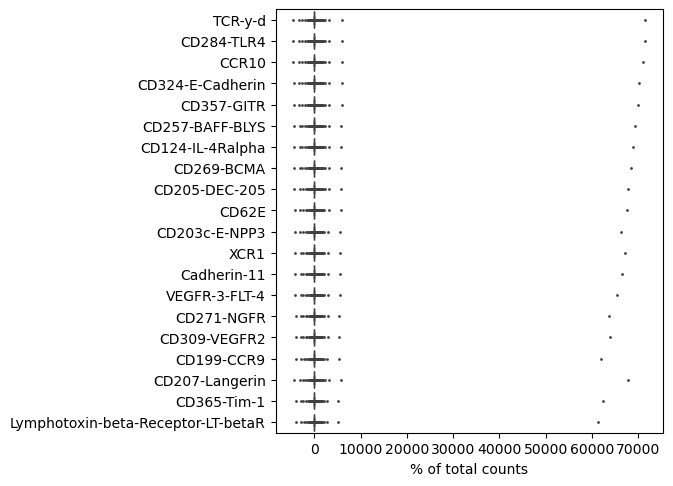

In [9]:
sc.pl.highest_expr_genes(predictions, n_top=20)

In [18]:
predictions.obs['predicted_aml_class']

GSM5613786_2021-03-09-AMLMS3730_X2021.03.09.AMLMS3730.GTTGCTCTCACCTTGC    False
GSM5613780_2020-10-06-AML4897_X2020.10.06.AML4897.CATCGGGAGCTTCATG         True
GSM5613761_2019-11-19-count-2_X2019.11.19.count.2.CTACAGAAGGGACCAT         True
GSM5613762_2019-11-26-count-1_X2019.11.26.count.1.CTGTGAAAGGGACCAT         True
GSM5613769_2020-03-18-count-1_X2020.03.18.count.1.ATCACTTTCTGGGAGA        False
                                                                          ...  
GSM5613751_2019-08-29-count-1_X2019.08.29.count.1.CAGATACAGCCACTCG        False
GSM5613757_2019-11-04-count-1_X2019.11.04.count.1.TCATGTTGTCTTACAG        False
GSM5613751_2019-08-29-count-1_X2019.08.29.count.1.CTTCCGAGTTGAGAGC        False
GSM5613758_2019-11-04-count-2_X2019.11.04.count.2.AATGGCTCATATGAAG        False
GSM5613759_2019-11-04-count-3_X2019.11.04.count.3.CTTCTCTCAATCTAGC        False
Name: predicted_aml_class, Length: 10000, dtype: category
Categories (2, object): ['False', 'True']

Computing PCA from fused embeddings...


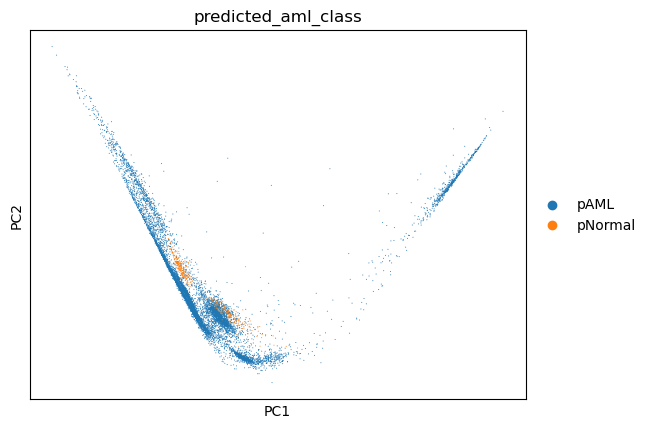

In [10]:
# Compute PCA using fused embeddings
print("Computing PCA from fused embeddings...")

# Store original embeddings
fused_embeddings = predictions.obsm['X_fused_embeddings'].copy()

# Compute PCA using scanpy
sc.pp.pca(predictions, n_comps=50, use_highly_variable=False)

sc.pl.pca(
    predictions,
    color=["predicted_aml_class"],
    size=2,
)




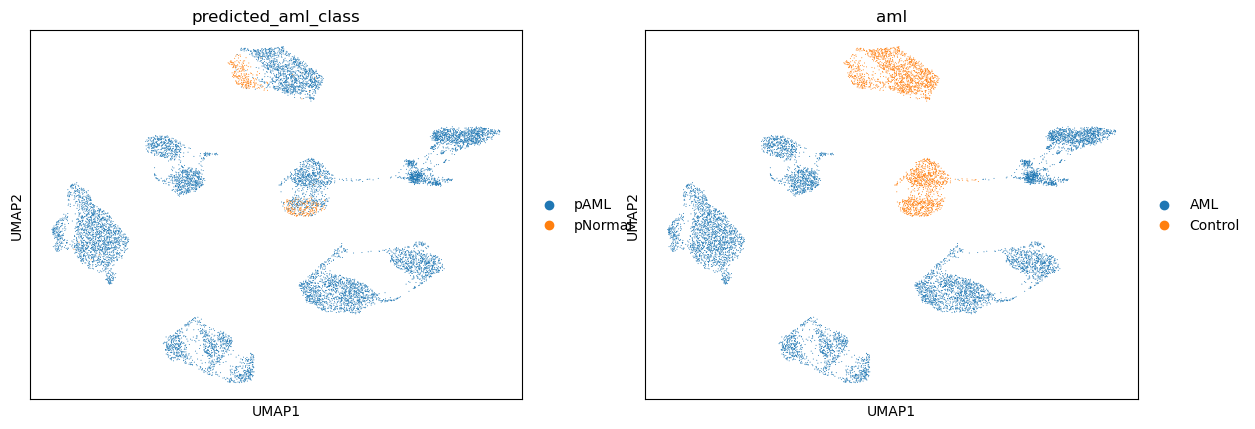

In [11]:

sc.tl.umap(predictions)

sc.pl.umap(
    predictions,
    color=["predicted_aml_class","aml"],
    size=2,
)

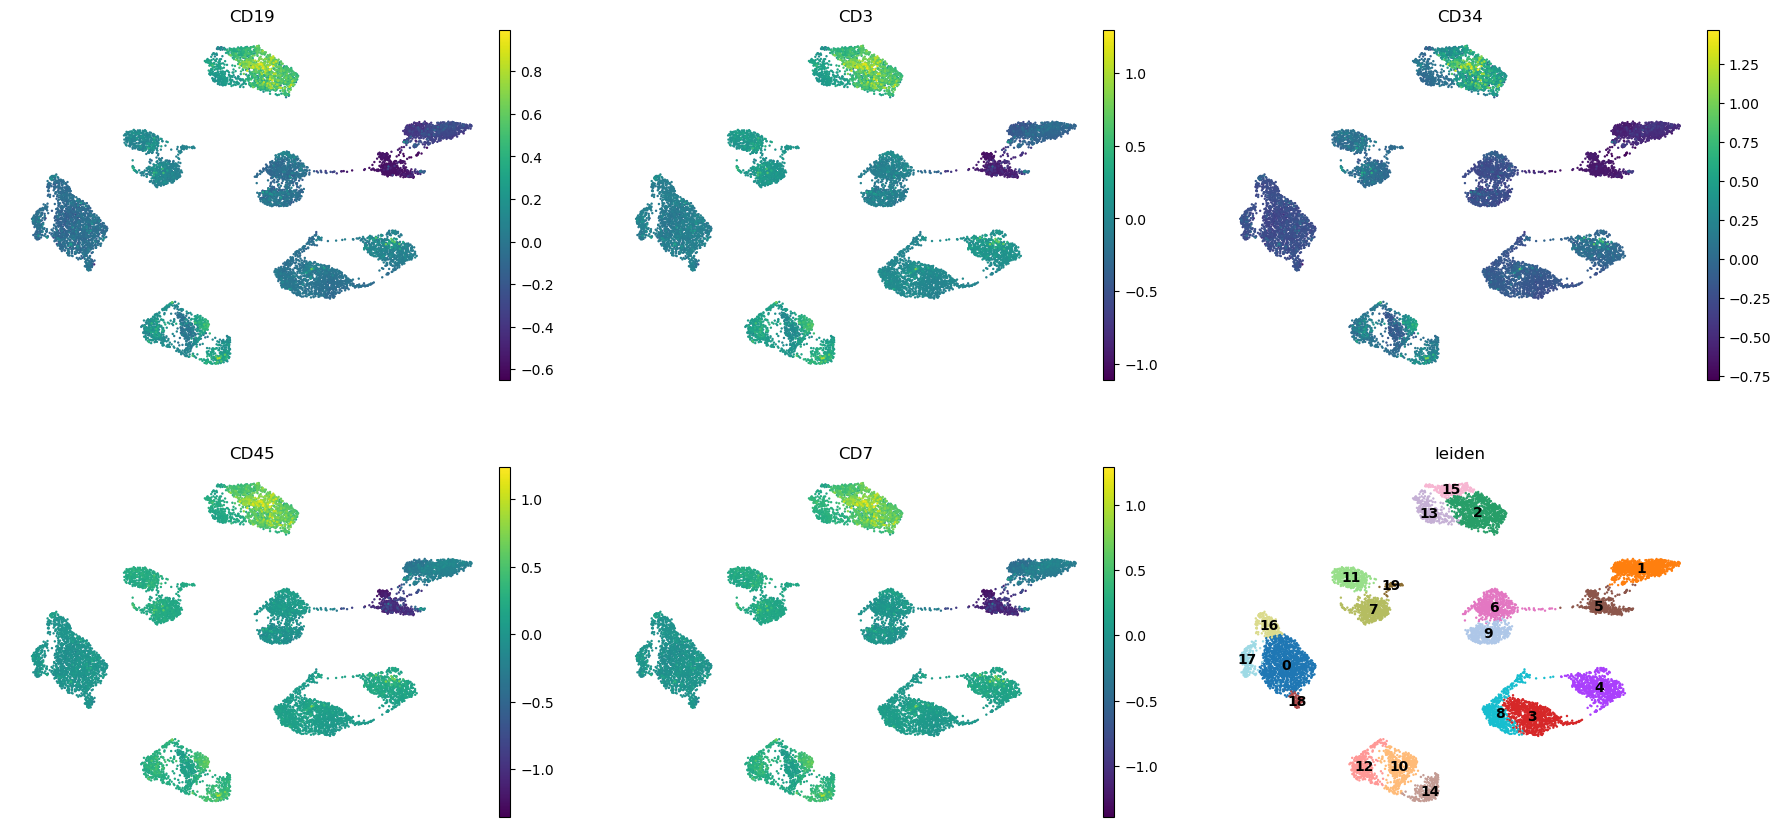

In [12]:
dc_cluster_genes = ["CD19","CD3","CD34","CD45","CD7"]
sc.pl.umap(
    predictions,
    color=[*dc_cluster_genes, "leiden"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

Adding true ADT values to predictions...
True ADT stored in predictions.layers['true_adt']: (10000, 279)

Computing correlations per marker...
Added correlations to predictions.var
  Mean correlation: 0.2488

Computing cell-wise correlations...
Added cell correlations to predictions.obs
  Mean cell correlation: 0.4247


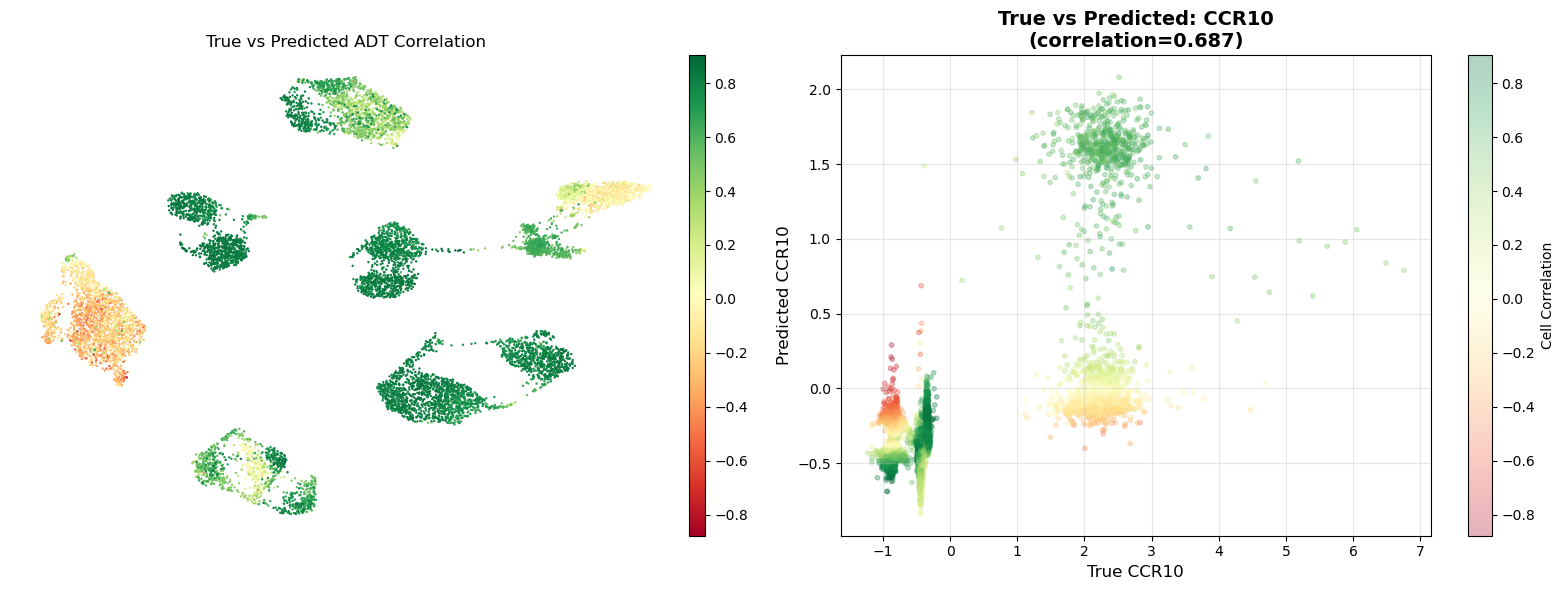


✅ Visualization complete!
True ADT values in: predictions.layers['true_adt']
Predicted ADT values in: predictions.X
Saved: true_vs_predicted_correlation.png


In [13]:
from scipy.stats import pearsonr

# Add true ADT values to predictions
print("Adding true ADT values to predictions...")

# Convert ADT test data to dense if sparse
if hasattr(adt_test_subset.X, 'toarray'):
    true_adts = adt_test_subset.X.toarray()
else:
    true_adts = adt_test_subset.X.copy()

# Store in layers instead of obs (since it's a matrix)
predictions.layers['true_adt'] = true_adts
print(f"True ADT stored in predictions.layers['true_adt']: {true_adts.shape}")

# For visualization, let's create correlation per marker
print("\nComputing correlations per marker...")

# Calculate correlations for each marker
marker_correlations = []
for i in range(true_adts.shape[1]):
    if np.std(true_adts[:, i]) > 0 and np.std(adt_predictions_np[:, i]) > 0:
        corr, _ = pearsonr(true_adts[:, i], adt_predictions_np[:, i])
        marker_correlations.append(corr)
    else:
        marker_correlations.append(0.0)

# Add to var (marker metadata)
if not hasattr(predictions, 'var'):
    predictions.var = pd.DataFrame(index=predictions.var_names)
    
predictions.var['correlation'] = marker_correlations
print(f"Added correlations to predictions.var")
print(f"  Mean correlation: {np.mean(marker_correlations):.4f}")

# Calculate cell-wise correlations
print("\nComputing cell-wise correlations...")
cell_correlations = []
for cell_idx in range(len(predictions)):
    true_values = true_adts[cell_idx, :]
    pred_values = adt_predictions_np[cell_idx, :]
    
    if np.std(true_values) > 0 and np.std(pred_values) > 0:
        corr, _ = pearsonr(true_values, pred_values)
        cell_correlations.append(corr)
    else:
        cell_correlations.append(0.0)

predictions.obs['adt_correlation'] = cell_correlations
print(f"Added cell correlations to predictions.obs")
print(f"  Mean cell correlation: {np.mean(cell_correlations):.4f}")

# Visualize using scanpy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: UMAP colored by ADT correlation
ax1 = axes[0]
sc.pl.umap(predictions, color='adt_correlation', 
          ax=ax1, show=False, title='True vs Predicted ADT Correlation', 
          frameon=False, cmap='RdYlGn')

# Plot 2: Scatter plot of true vs predicted for top correlated markers
ax2 = axes[1]

# Get top correlated marker
top_marker_idx = np.argmax(marker_correlations)
top_marker_name = predictions.var_names[top_marker_idx]

# Plot
ax2.scatter(true_adts[:, top_marker_idx], adt_predictions_np[:, top_marker_idx], 
           alpha=0.3, s=10, c=cell_correlations, cmap='RdYlGn')
ax2.set_xlabel(f'True {top_marker_name}', fontsize=12)
ax2.set_ylabel(f'Predicted {top_marker_name}', fontsize=12)
ax2.set_title(f'True vs Predicted: {top_marker_name}\n(correlation={marker_correlations[top_marker_idx]:.3f})', 
              fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
plt.colorbar(ax2.collections[0], ax=ax2, label='Cell Correlation')

plt.tight_layout()
plt.savefig('true_vs_predicted_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Visualization complete!")
print(f"True ADT values in: predictions.layers['true_adt']")
print(f"Predicted ADT values in: predictions.X")
print(f"Saved: true_vs_predicted_correlation.png")